In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import csv
import pyart
import subprocess
import os
import sage_data_client
import urllib
import tempfile
from xmovie import Movie
import requests
import imageio as io
import urllib
import tempfile
import datetime
import cftime
from PIL import Image
from matplotlib import image
%matplotlib inline




## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/miniconda3/envs/sage/lib/python3.11/site-packages/xmovie/core.py:21: UserWarning: Optional dependency `tqdm` not found. This will make progressbars a lot nicer.     Install with `conda install -c conda-forge tqdm`
  warnings.warn(


In [32]:
def readtofile(uurl, ff, username, password):
    r = requests.get(uurl, auth=(username,password))
    if r.status_code == 200:
        print('running')
        with open(ff, 'wb') as out:
            for bits in r.iter_content():
                out.write(bits)
    
    return True

def read_mob_from_sage(url, datet):
    print(url)
    tempf = tempfile.NamedTemporaryFile()
    try:
        readtofile(url, tempf.name, 'ASK', 'SCOTT')
        head = []
        with open(tempf.name, 'r') as f:
            reader = csv.reader(f, delimiter=';')
            for i in range(7):
                headers = next(reader)
                head.append(headers)
            _ = next(reader)
            data = np.expand_dims(np.flipud(np.array(list(reader)).astype(float)), axis=0)
        print(data.shape)
        tt = datet.to_pydatetime()
        ctime = cftime.datetime(tt.year, tt.month, tt.day, hour=tt.hour, minute=tt.minute, second=tt.second)

        ds = xr.Dataset({
        'thermalimage': xr.DataArray(
                    data   = data,   # enter data here
                    dims   = ['time', 'y', 'x'],
                    coords = {'time': [ctime],
                             'y' : np.arange(data.shape[1]),
                             'x' : np.arange(data.shape[2])},
                    attrs  = {
                        '_FillValue': -999.9,
                        'units'     : 'celsius'
                        }
                    ),
                },
            attrs = {'Source': 'MOBOTIX M16 camera operated by Sage',
                    'URL' : url}
        )
    except urllib.error.HTTPError:
        ds="ERROR"
    
    return ds

def get_latest_thermal(lookback = 2, imnum=-1, node='W071'):
    now = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
    an_hour_ago = (datetime.datetime.utcnow() -  \
                        datetime.timedelta(hours=lookback)).strftime('%Y-%m-%dT%H:%M:%SZ')

    df = sage_data_client.query(
        start = an_hour_ago,
        end = now, 
        filter={
            "plugin": "registry.sagecontinuum.org/bhupendraraut/mobotix-scan.*",
            "vsn": node
        }
    )

    targets = []
    times = []
    for i in range(len(df)):
        try:
            if 'csv' in df.iloc[i].value:
                targets.append(df.iloc[i].value)
                times.append(df.iloc[i].timestamp)
        except:
            pass

    #print(targets)
    
    return read_mob_from_sage(targets[imnum], times[imnum])

def get_latest_mobvis(lookback = 2, imnum=-1, node="W071"):
    now = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
    an_hour_ago = (datetime.datetime.utcnow() -  \
                        datetime.timedelta(hours=lookback)).strftime('%Y-%m-%dT%H:%M:%SZ')

    df = sage_data_client.query(
        start = an_hour_ago,
        end = now, 
        filter={
            "plugin": "registry.sagecontinuum.org/bhupendraraut/mobotix-scan.*",
            "vsn": node
        }
    )

    targets = []
    times = []
    for i in range(len(df)):
        try:
            if 'jpg' in df.iloc[i].value:
                targets.append(df.iloc[i].value)
                times.append(df.iloc[i].timestamp)
        except:
            pass

    tempf = tempfile.NamedTemporaryFile()
    readtofile(targets[imnum], tempf.name+'.jpg', 'ASK', 'SCOTT')
    
    return_im = image.imread(tempf.name+'.jpg', format='jpg')
    shp = return_im.shape
    print('returning')
    
    return return_im[:, 0:int(shp[1]/2), :]


https://storage.sagecontinuum.org/api/v1/data/mobotix-scan/sage-mobotix-scan-0.23.3.24/00002cea7fa0aeb3/1680284058375473185-right_336x252_14bit.thermal.uint_position9.csv
running
(1, 252, 336)


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_37998/2144225320.py:25: UserWarning: Discarding nonzero nanoseconds in conversion.
  tt = datet.to_pydatetime()


[]
running
returning


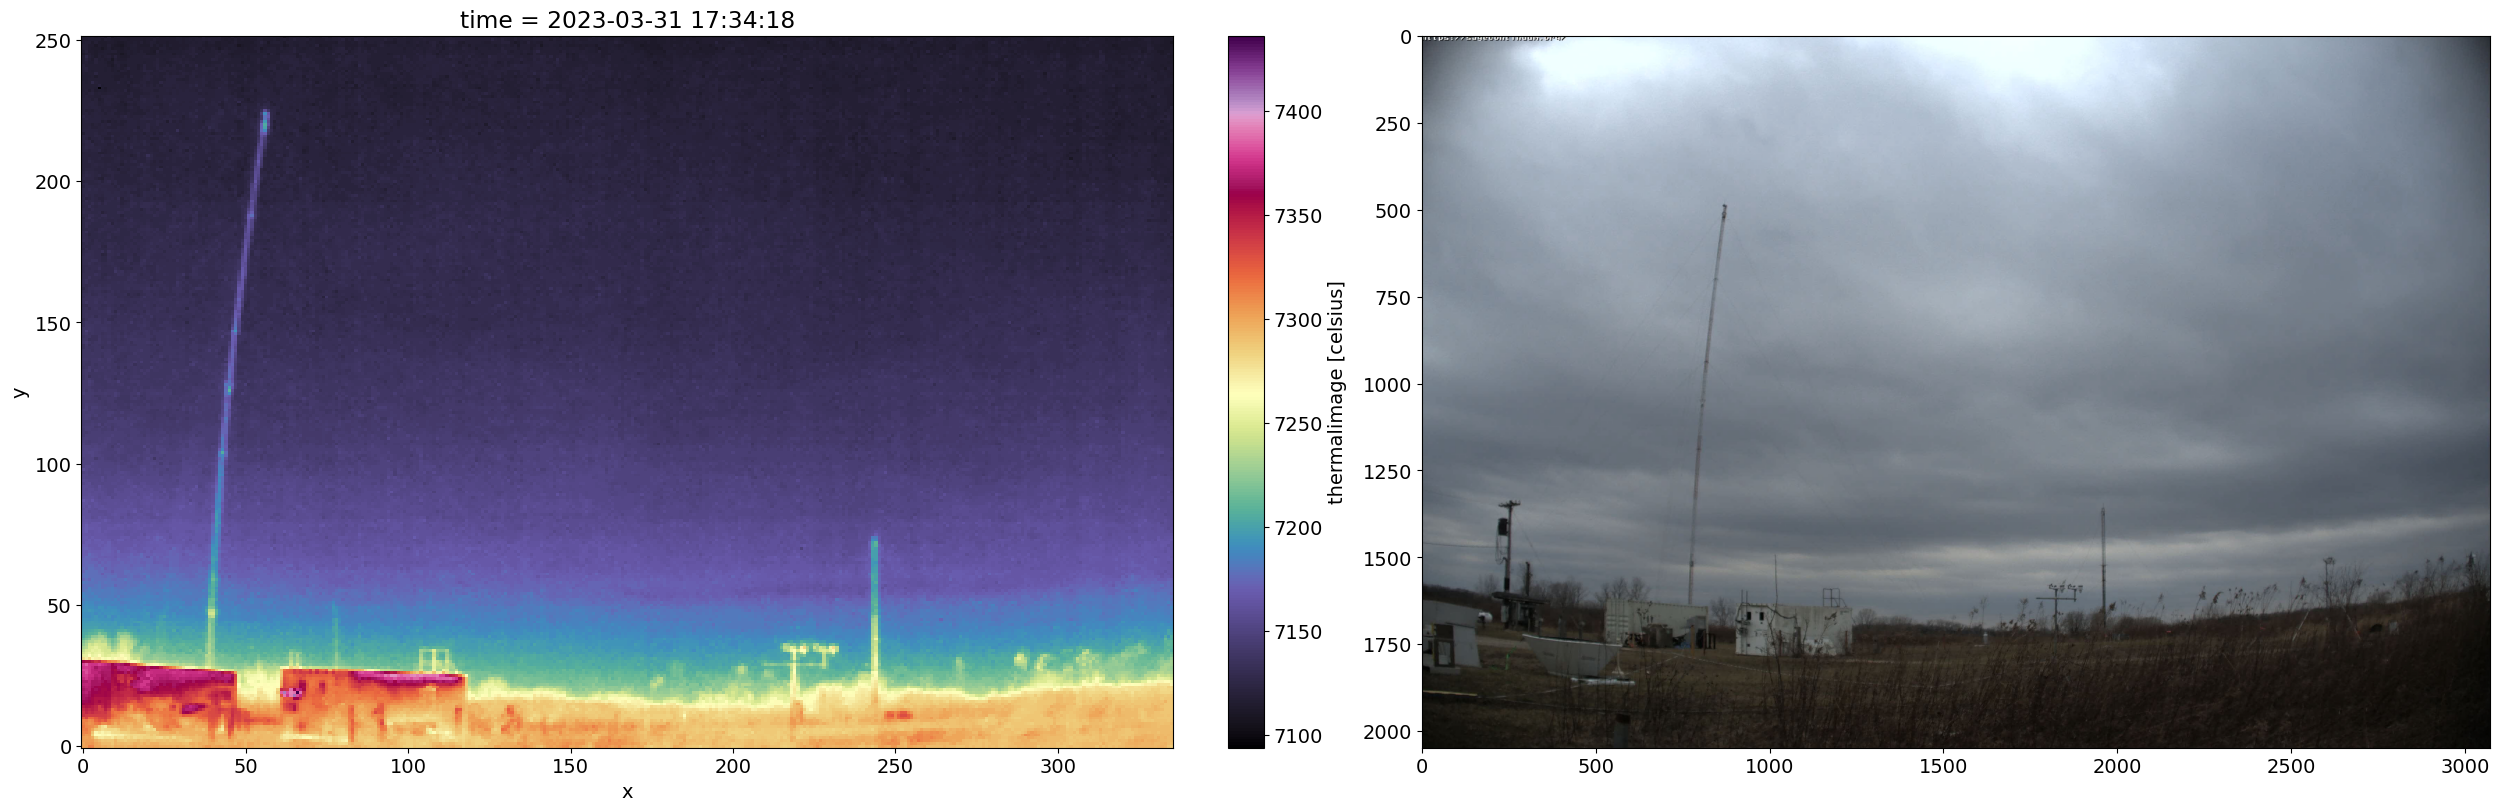

In [35]:

ii = -4
fig, axs = plt.subplots( ncols=2, nrows=1, figsize=[25,8], constrained_layout=True)
get_latest_thermal(lookback=8, imnum=ii, node='V032').thermalimage.plot(cmap=pyart.graph.cm_colorblind.ChaseSpectral, 
                                                        ax=axs[0], vmin = None, vmax = None)
im = get_latest_mobvis(lookback=8, imnum=ii, node='V032')
axs[1].imshow(im)